# INF8111 - Fouille de données


## TP1 AUTOMNE 2024 - Préparation de données




### Instructions de remise

#### Membres de l'équipe :
    - Nom (Matricule) 1
    - Nom (Matricule) 2
    - Nom (Matricule) 3
    
#### Délivrable :

Vous devez soumettre ce notebook sur Moodle dans la boite de remise sous le nom TP1_NomDuMembre1_NomDuMembre2_NomDuMembre3.ipynb.

**NB**: Tout travail en retard sera pénalisé d'une valeur de 10\% par jour de retard.


## Introduction et objectifs

### Importation des différents modules

In [51]:
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib
!pip install plotly
!pip install requests
!pip install shap

In [31]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn import linear_model
import shap
import scipy.stats as stats

### Téléchargement des données

In [196]:
import requests
response = requests.get('https://docs.google.com/spreadsheets/d/1caaR9pT24GNmq3rDQpMiIMJrmiTGarbs/export?format=csv&gid=1150341366')
assert response.status_code == 200, 'Wrong status code'
# convert the csv to a pandas dataframe
with open('data.csv', 'w') as f:
    f.write(response.text)

df = pd.read_csv('data.csv')

Le but de ce notebook est d'effectuer le prétraitement du dataset [HousePricePrediction](https://docs.google.com/spreadsheets/d/1caaR9pT24GNmq3rDQpMiIMJrmiTGarbs/edit#gid=1150341366) qui pourra être par la suite être utilisé pour entraîner un modèle de prédiction de prix de maisons.

## Préparation des données

Plusieurs étapes sont nécessaires pour préparer un dataset pour la fouille des données
- **Nettoyage des données** :
    - Suppression des attributs inutiles
    - Gestion des valeurs manquantes
    - Gestion des valeurs aberrantes
- **Transformation des données** :
    - Encodage des données
    - Normalisation des données
- **Sélection des attributs** :
    - Suppression des attributs les plus fortement corrélés

## Sommaire

1. [Première observation des données](#1.-Première-observation-des-donnees)
2. [Nettoyage des données](#2.-Nettoyage-des-données)
   1. [Suppression des attributs inutiles](#2.1.-Suppression-des-attributs-inutiles)
   2. [Gestion des valeurs manquantes](#2.2.-Gestion-des-valeurs-manquantes)
   3. [Détection des valeurs aberrantes](#2.3.-Détection-des-valeurs-aberrantes)
3. [Transformation des données](#3.-Transformation-des-données)
   1. [Encodage des attributs de type `object`](#3.1.-Encodage-des-attributs-de-type-object)
   2. [Normalisation des données](#3.2.-Normalisation-des-données)
4. [Sélection des attributs](#4.-Sélection-des-variables)
   1. [Suppression des attributs corrélées](#4.1.-Suppression-des-variables-corrélées)
5. [Récapitulatif des procédés](#5.-Récapitulatif-des-prétraitements)
6. [Entrainement d'un modèle de régression linéaire](#6.-Récapitulatif-des-prétraitements)
    1. [Rappel du concept](#6.1.-Rappel-concept)
    2. [Application](#6.2.-Application)
    3. [Sélection des attributs importants](#6.3.-Sélection-des-attributs-importants)
7. [Méthode des écarts interquartiles ou IRQ](#7.-Récapitulatif-des-prétraitements)

## 1. Exploration des données (5 points)

Nous vous avons fourni le fichier *data.csv* avec l'exécution de la deuxième cellule. Il contient l'ensemble des données. Chaque ligne contient les données d'une vente. La description des attributs du dataset est la suivante:

| # | Feature Name | Description |
|---|--------------|-------------|
| 1 | Id           | Numéro de vente / To count the records. |
| 2 | MSSubClass   | Type de logement / Identifies the type of dwelling involved in the sale. |
| 3 | MSZoning     | Zonage / Identifies the general zoning classification of the sale. |
| 4 | LotArea      | Superficie du logement / Lot size in square feet. |
| 5 | LotConfig    | Configuration du logement / Configuration of the lot |
| 6 | BldgType     | Type de logement / Type of dwelling |
| 7 | OverallCond  | Etat général / Rates the overall condition of the house |
| 8 | YearBuilt    | Année de contruction / Original construction year |
| 9 | YearRemodAdd | Année de rénovation / Remodel date (same as construction date if no remodeling or additions). |
| 10| Exterior1st  | Type de revêtement extérieur / Exterior covering on house |
| 11| BsmtFinSF2   | Surface de vie / Type 2 finished square feet. |
| 12| TotalBsmtSF  | Surface totale de la base / Total square feet of basement area |
| 13| SalePrice    | Prix de vente à prédire / To be predicted |

On visualise le dataset pour avoir une idée de ce qu'il contient et des prétraitements à effectuer.

### 1.1 - Question 1 (2.5 points)

**Combien d'éléments contient le dataset ? Quelles sont les types des attributs du dataset ?**

In [197]:
elements = df.shape[0]
print(f"Nombre d'éléments dans le dataset: {elements}")

for column, dtype in df.dtypes.items():
    print(f"{column}: {dtype}")

Nombre d'éléments dans le dataset: 2919
Id: int64
MSSubClass: int64
MSZoning: object
LotArea: int64
LotConfig: object
BldgType: object
OverallCond: int64
YearBuilt: int64
YearRemodAdd: int64
Exterior1st: object
BsmtFinSF2: float64
TotalBsmtSF: float64
SalePrice: float64


### 1.2 - Question 2 (2.5 points)

**Quelles sont les valeurs uniques des attributs de type `object` ?**

In [198]:
colonnes_type_object = df.select_dtypes(include="object")
for colonne in colonnes_type_object:
    valeurs_uniques = df[colonne].unique()
    print(f"Valeurs uniques de la colonne '{colonne}': {valeurs_uniques}")

Valeurs uniques de la colonne 'MSZoning': ['RL' 'RM' 'C (all)' 'FV' 'RH' nan]
Valeurs uniques de la colonne 'LotConfig': ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
Valeurs uniques de la colonne 'BldgType': ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
Valeurs uniques de la colonne 'Exterior1st': ['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'CemntBd'
 'Plywood' 'AsbShng' 'Stucco' 'BrkComm' 'AsphShn' 'Stone' 'ImStucc'
 'CBlock' nan]


## 2. Nettoyage des données (30 points)

### 2.1 Suppression des attributs inutiles

### 2.1.1 - Question 3 (5 points)

**Pourquoi on peut supprimer l'attribut `Id` dans le cas de ce TP? Effectuez cette suppression.**

Nous pouvons supprimer puisque ce type d'attribut ne contient pas d'information utile pour l'analyse des prix ou pour notre modèle de prédiction. En effet, il ne contribue pas directement à la relation entre les autres variables et le prix de vente. Cet attribut `Id` represente simplement un identifiant unique pour chaque maison. 

In [199]:
df = df.drop(columns=["Id"])
print(df.head())

   MSSubClass MSZoning  LotArea LotConfig BldgType  OverallCond  YearBuilt  \
0          60       RL     8450    Inside     1Fam            5       2003   
1          20       RL     9600       FR2     1Fam            8       1976   
2          60       RL    11250    Inside     1Fam            5       2001   
3          70       RL     9550    Corner     1Fam            5       1915   
4          60       RL    14260       FR2     1Fam            5       2000   

   YearRemodAdd Exterior1st  BsmtFinSF2  TotalBsmtSF  SalePrice  
0          2003     VinylSd         0.0        856.0   208500.0  
1          1976     MetalSd         0.0       1262.0   181500.0  
2          2002     VinylSd         0.0        920.0   223500.0  
3          1970     Wd Sdng         0.0        756.0   140000.0  
4          2000     VinylSd         0.0       1145.0   250000.0  


### 2.2 Gestion des valeurs manquantes

Pour gérer les valeurs manquantes, plusieurs solutions s'offrent à nous :
- Remplacer par la valeur la plus fréquente (le mode)
- Remplacer par la valeur moyenne/médiane
- Suppression des lignes contenant des valeurs manquantes

Pour ce TP, nous utiliserons la dernière option car nous avons peu de valeurs manquantes.

#### 2.2.1 - Question 4 (2.5 points)

**Quels attributs contiennent des valeurs manquantes ?**

In [200]:
attributs_valeurs_manquantes = df.columns[df.isnull().any()]
print(attributs_valeurs_manquantes)

Index(['MSZoning', 'Exterior1st', 'BsmtFinSF2', 'TotalBsmtSF', 'SalePrice'], dtype='object')


#### 2.2.2 - Question 5 (2.5 points)

On peut alors gérer les valeurs manquantes colonne par colonne. L'attribut `SalePrice` n'est pas pris en considération car les valeurs manquantes sont justement les valeurs que nous voulons prédire.

**Supprimer les lignes contenant les valeurs manquantes. Implémentez la fonction `delete_missing_values` qui retire ces données**.

In [201]:
def delete_missing_values(dataset):
    """
    This function deletes row whom a value is missing.

    :param dataset: ensemble des données
    :return:
      dataset traitée
    """
    dataset_clean = dataset.dropna(subset=[col for col in dataset.columns if col != 'SalePrice'])
    return dataset_clean


In [202]:
df = delete_missing_values(df)

Les données manquantes pour la colonne `SalePrice` sont celles du dataset de test. On laisse donc ces valeurs manquantes car on veut appliquer le même prétraitement sur les données de test.

### 2.2.3 - Question 6 (10 points)

On veut néanmoins que les données d'entrainement suivent une distribution gaussienne.

**Implémenter le fonction `plot_hist`. Cette fonction doit permettre d'afficher la distribution des valeurs de l'attribut `SalePrice` ainsi que la loi normale de même moyenne et variance.**

In [203]:
def plot_hist(prices):
    """
    Affiche la distribution du prix de vente

    :param prices: ensemble des prix.
    """
    moyenne = np.mean(prices)
    variance = np.std(prices)

    plt.hist(prices, bins=30, alpha=0.6, color='blue', density=True, label='Distribution des prix')

    x = np.linspace(min(prices), max(prices), 1000)
    dist_normal = stats.norm.pdf(x, moyenne, variance)

    plt.plot(x, dist_normal, color='red', label='Loi normale')

    plt.title('Distribution des prix de ventes')
    plt.xlabel('Prix de vente')
    plt.ylabel('Densité')
    plt.legend()

    plt.show()

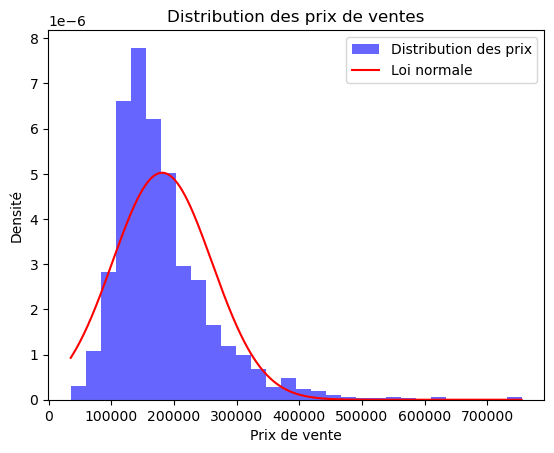

In [204]:
plot_hist(df['SalePrice'])

Vous devez obtenir une distribution des valeurs de `SalePrice` proches d'une distribution normale mais légèrement asymétrique. On peut alors appliquer une transformation logarithmique pour approcher d'une distribution normale symétrique.

**Effectuer cette transformation sur notre ensemble de données.**

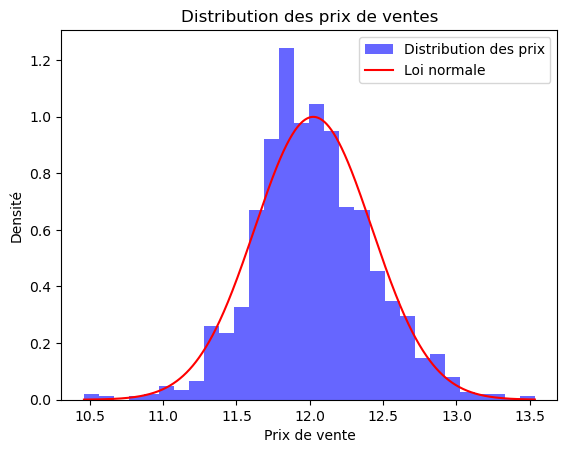

In [205]:
plot_hist(np.log(df['SalePrice']))

### 2.3 Détection des valeurs aberrantes

En pratique, la méthode de détection d'une valeur aberrante nécessite de se poser les questions suivantes:
- Quelles valeurs seraient incohérentes pour chaque colonne ?
- Quelles valeurs peuvent être problématiques pour l'utilisation de ces données ? Exemple: pour une régression linéaire, on préfère avoir des valeurs distribuées suivant une loi normale.

Avec ces éléments, on peut:
- Fixer des seuils de tolérance pour les valeurs aberrantes
- Utiliser des algorithmes de détection de valeurs aberrantes (ex: clustering, IRQ, [QTest](https://plotly.com/python/v3/outlier-test/), ...)

A noter que suivant les méthodes, les valeurs détectées comme aberrantes peuvent être différentes.

La méthode IRQ fait l'objet d'une partie bonus, en fin de ce notebook.

### 2.3.1 Question 7 (10 points)

Ici comme nous allons réaliser une régression linéaire, nous allons visuellement voir si certains points s'écartent franchement de la droite de régression.

On sait que l'on veut effectuer une régression linéaire pour prédire `SalePrice`. On peut donc visualiser les valeurs de chaque attribut en fonction de `SalePrice` pour détecter la présence de valeurs aberrantes.

**Implémenter la fonction `plot_line`. Elle doit permettre de visualiser la relation entre un attribut donné et `SalePrice`.**

In [206]:
def plot_line(attr):
    """
    Affiche la relation entre attr et SalePrice

    :param attr: attribut à comparer à SalePrice
    """
    plt.figure(figsize=(8, 6))
    
    # Vérifier si l'attribut est numérique ou catégoriel
    if df[attr].dtype in ['int64', 'float64']:
        # numérique, utiliser regplot
        sns.regplot(x=df[attr], y=df['SalePrice'], line_kws={"color": "red"})
        plt.title(f"Relation entre {attr} et le prix de vente")
    else:
        # catégoriel, utiliser boxplot
        sns.boxplot(x=df[attr], y=df['SalePrice'])
        plt.title(f"Relation entre {attr} et le prix de vente")
        plt.xticks(rotation=45)
    
    plt.xlabel(attr)
    plt.ylabel('Prix de vente')
    plt.show()

**Afficher les relations de tous les attributs avec `SalePrice`. Peut-on y déceler des valeurs aberrantes ?**

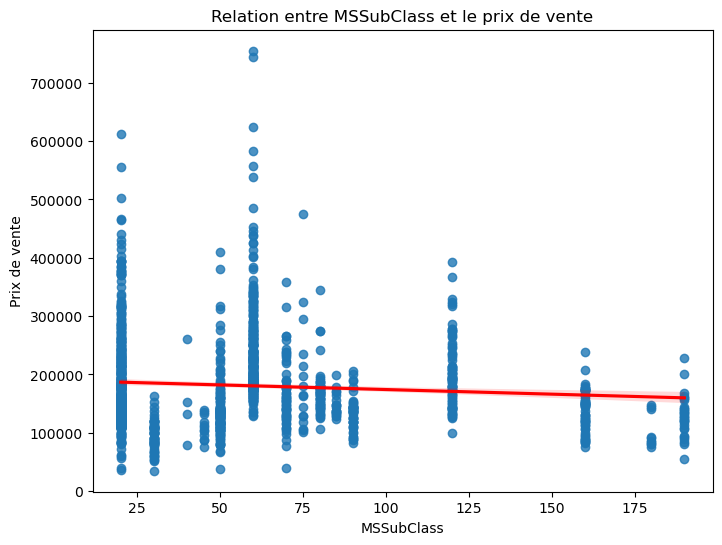

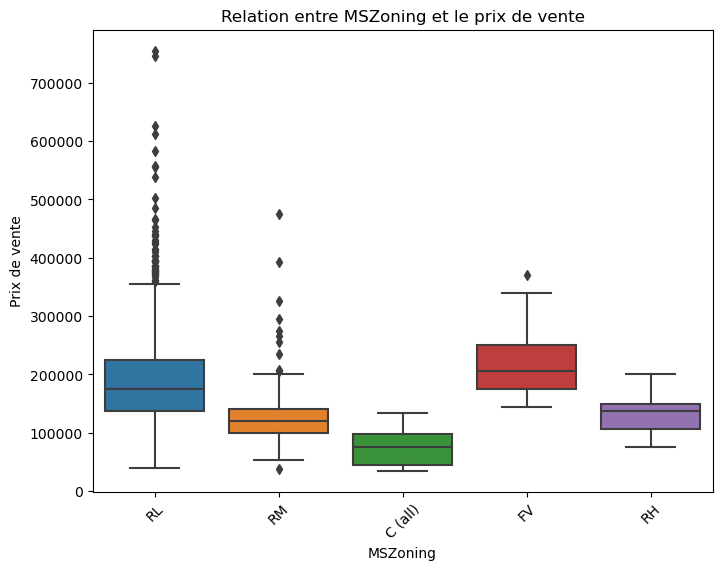

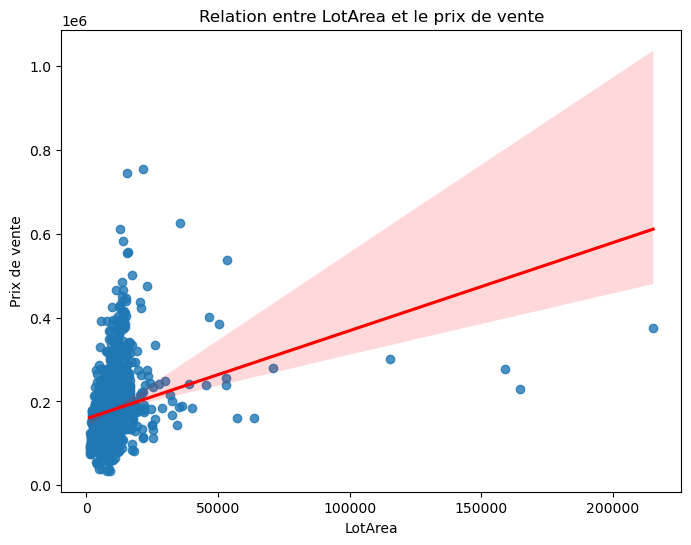

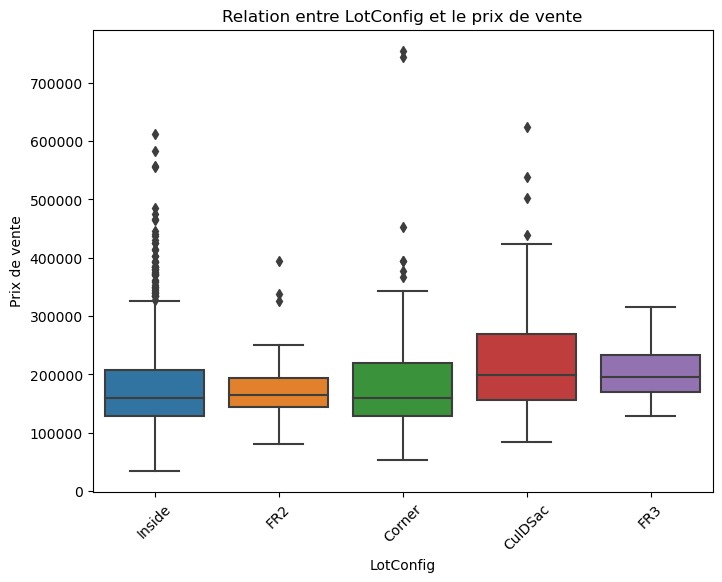

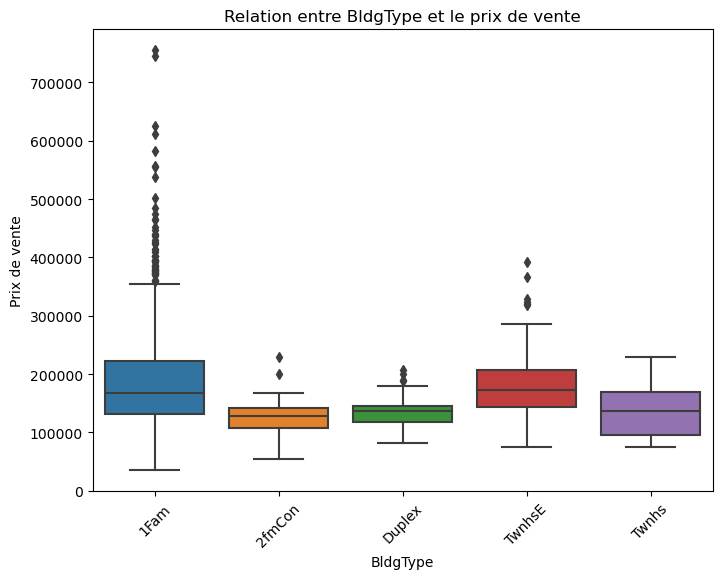

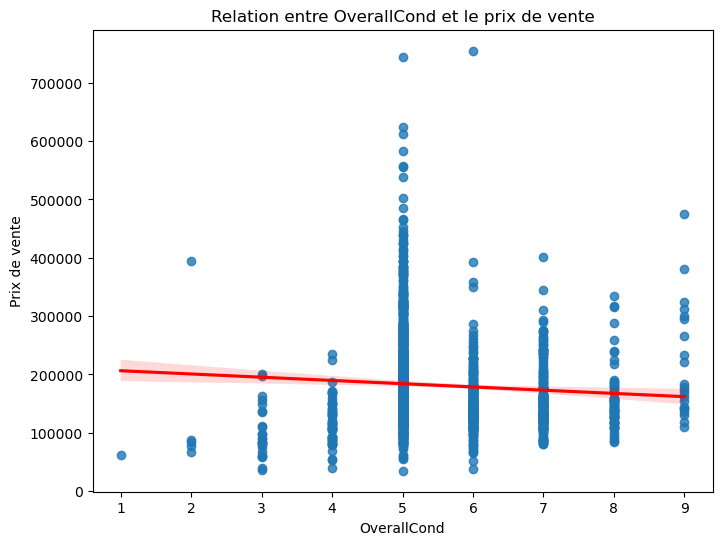

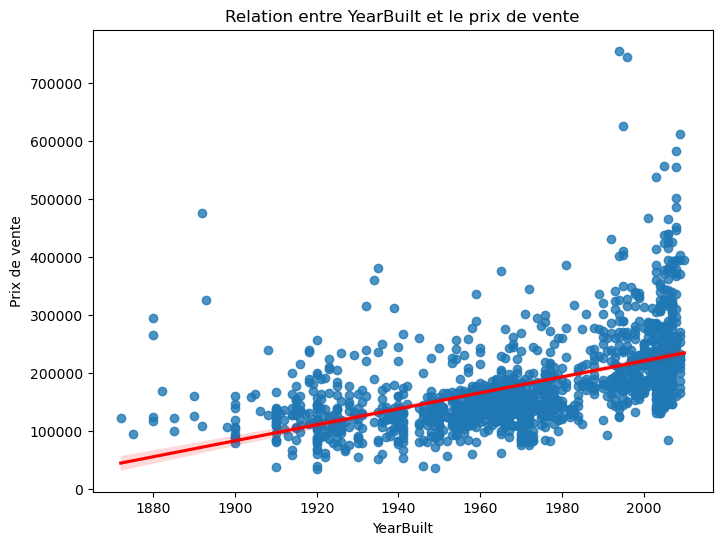

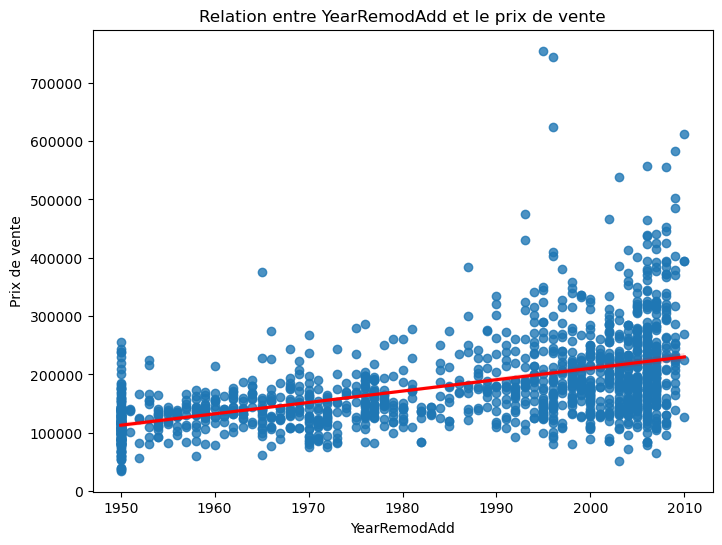

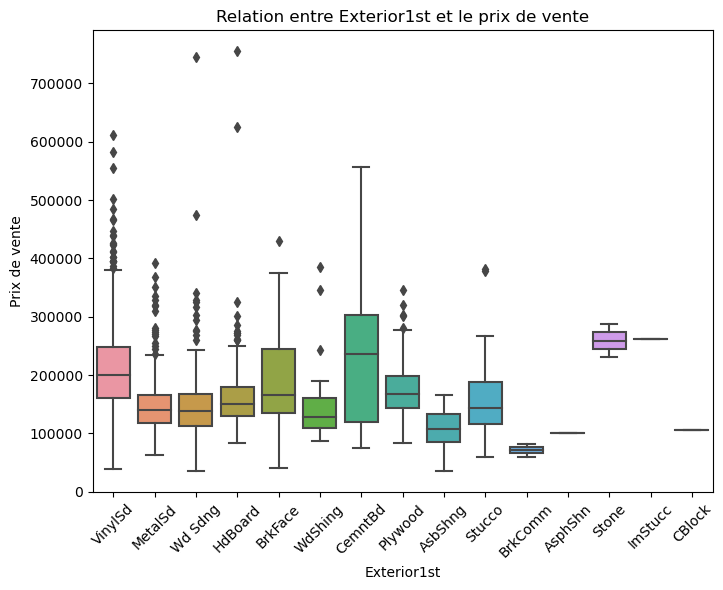

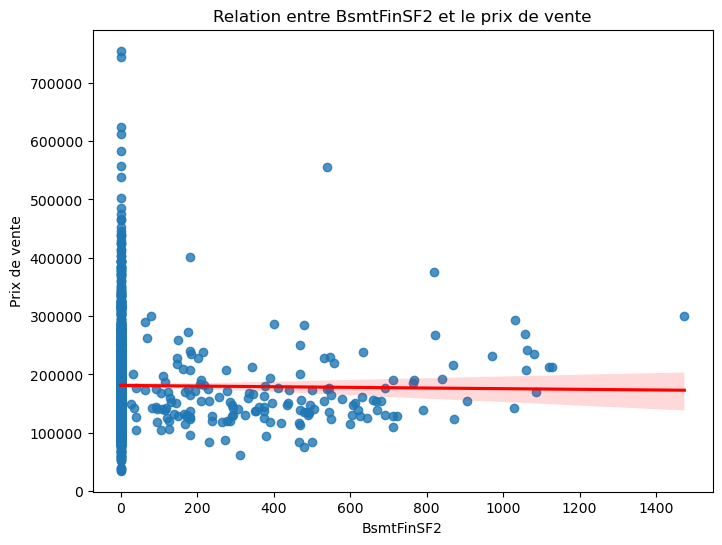

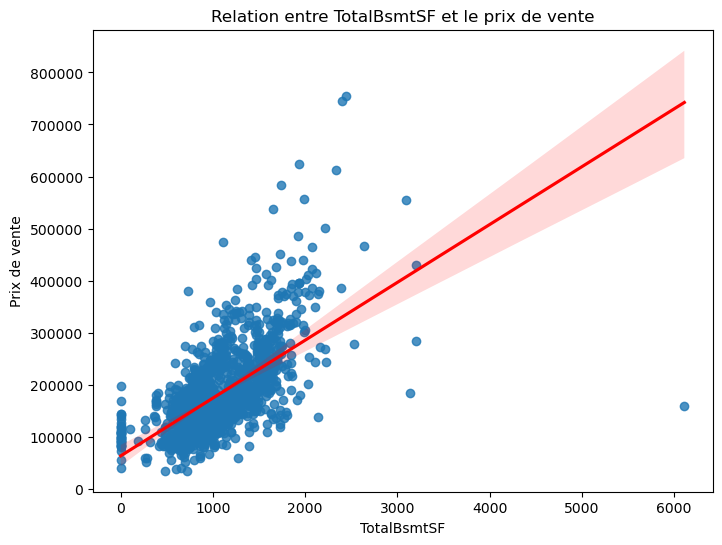

In [207]:
attributs = df.columns
for attrib in attributs:
    if attrib != 'SalePrice':
        plot_line(attrib)

## 3. Transformation des données (10 points)

### 3.1 Encodage des attributs de type `object`

Les attributs de type `object` étant catégoriques (voire partie 1), on peut effectuer un `one hot encoding` de ces attributs. `Pandas` permet d'effectuer cela avec la fonction `get_dummies()`. Cela nous permettra d'obtenir un dataset contenant uniquement des attributs de type `int` ou `float`.


#### 3.1.1 Question 8 (5 points)

**Encodez les attributs de type `object` avec un `one hot encoding`**

In [208]:
colonnes_to_encode = list(df.select_dtypes(include=['object']).columns)
print(colonnes_to_encode)
df = pd.get_dummies(df, columns=colonnes_to_encode, dtype=int)

['MSZoning', 'LotConfig', 'BldgType', 'Exterior1st']


### 3.2 Normalisation des données

Pour faciliter l'entraînement du modèle, on peut normaliser les données. `sklearn` permet d'effectuer cela avec les fonctions suivantes :

*   `StandardScaler()` normalise les données en soustrayant la moyenne et en divisant par l'écart-type
*   `MinMaxScaler()` normalise les données en les ramenant entre 0 et 1.

Dans la suite de ce TP, nous utiliserons la fonction `StandardScaler()`.

In [209]:
# A utiliser dans la partie 6.2
mu_sale_price = df["SalePrice"].mean()
sigma_sale_price = df["SalePrice"].std()

#### 3.2.1 Question 9 (5 points)

**Implémenter la fonction `normalize`. Elle doit réaliser la normalisation des données.**

In [210]:
def normalize(dataset):
    """
    Normalise les données du dataset.

    :param dataset: ensemble des données
    :return:
      dataset traitée
    """
    trans = preprocessing.StandardScaler()
    return trans.fit_transform(dataset)

In [211]:
df = normalize(df)
print(df)

[[ 0.06606554 -0.21550392 -0.51116217 ...  1.35718504 -0.40415178
  -0.1400035 ]
 [-0.87443011 -0.06865643  2.19449876 ... -0.73681921 -0.40415178
  -0.1400035 ]
 [ 0.06606554  0.14203779 -0.51116217 ...  1.35718504 -0.40415178
  -0.1400035 ]
 ...
 [-0.87443011  1.25935561  1.29261179 ...  1.35718504 -0.40415178
  -0.1400035 ]
 [ 0.65387533  0.03873377 -0.51116217 ... -0.73681921 -0.40415178
  -0.1400035 ]
 [ 0.06606554 -0.06520871 -0.51116217 ... -0.73681921 -0.40415178
  -0.1400035 ]]


## 4. Sélection des attributs corrélées (15 points)

### 4.1 Suppression des attributs corrélées

Pour améliorer la qualité de la prédiction, nous devons prendre en compte la corrélation entre attributs. L'objectif est donc de supprimer les attributs les plus fortement corrélées entre eux.

Pour ce faire, vous disposez des fonctions suivantes

* `corr()` de `Pandas` qui calcule la matrice de corrélation
* `heatmap()` de `seaborn` qui permet de visualiser la matrice de corrélation


#### 4.1.1 Question 10 (10 points)

**Implémenter la fonction `display_corr_matrix`. Elle doit permettre d'afficher la matrice de corrélation entre les différents attributs de nos données après normalisation des données.**

In [212]:
def display_corr_matrix(dataset):
    """
    Créer et affiche la matrice de corrélation des attributs liés au dataset.

    :param dataset: ensemble des données
    """

In [213]:
display_corr_matrix(df)

#### 4.1.2 Question 11 (5 points)

On peut alors choisir de supprimer les attributs qui sont fortement corrélées entre eux en définissant un seuil. Fixons ce seuil à 0.7.

**Quels sont les attributs fortement correlés selon le critère ci-dessus ? Supprimez ces attributs et affichez la nouvelle matrice de corrélation.**

In [214]:
#TODO

## 5. Récapitulatif des prétraitements

<img src=" 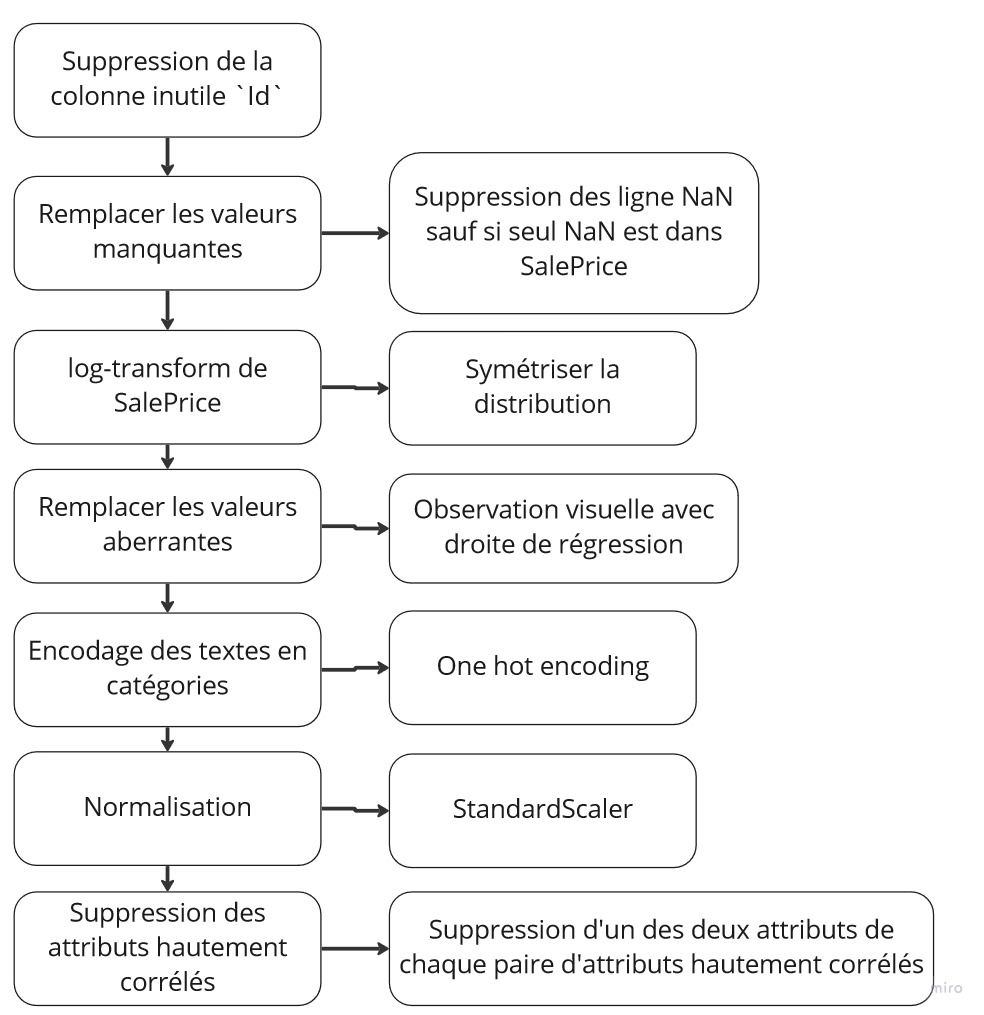" height="600px">

## 6. Entrainement d'un modèle de régression linéaire (30 points)

### 6.1 Rappel du concept

La régression linéaire consiste à trouver une fonction affine qui minimise la somme des carrés des erreurs. La fonction affine est définie par la formule suivante :
$$ f(x) = \beta_0 + \beta_1^T x $$
Nous tentons de trouver les paramètres $\beta_0$ et $\beta_1$ qui minimisent $\sum_{i=1}^n (f(x_i) - y_i)^2=||y-X\beta||^2$ où $X$ est la matrice des données fournies au modèle et $y$ le vecteur des `SalePrice`.

On veut trouver le minimum de cette fonction. On va utiliser `RidgeRegression` de `sklearn` pour trouver les paramètres $\beta_0$ et $\beta_1$. Ce module utilise la méthode des moindres carrés (`numpy.linalg.lstsq`) pour trouver les paramètres $\beta_0$ et $\beta_1$.

### 6.2 Application

#### 6.2.1 Question 12 (5 points)

Après avoir effectué le prétraitement, on peut commencer par séparer les données en un ensemble d'entraînement et un ensemble de test. Pour cela, les 1460 premières lignes contiennent les données d'entrainement. On peut ainsi séparer les données en deux ensembles.

**Compléter la structure suivante afin de diviser les données en deux sous-ensembles.**

In [215]:
data_train = {"x": pass, "y": pass, "df": pass}
data_pred = {"x": pass, "df": pass}

SyntaxError: invalid syntax (1528477451.py, line 1)

#### 6.2.2 Question 13 (7.5 points)

Une fois cette scission faite, on peut utiliser `RidgeRegression` pour effectuer la régression linéaire avec pénalisation de la norme L2.

**Compléter la fonction `ridge_regression`. Elle doit implémenter l'ensemble de la régression.**

*Pour cette question, vous devez retourner les coefficients de la regression linéaire. De plus, ce fonction doit modifier le paramètre `data_pred` en y ajoutant les valeurs prédites. Il est aussi nécéssaire de prendre en compte certaines modifications effectuées lors de la transformation des données*

In [ ]:
def ridge_regression(data_train, data_pred):
    """
    Réaliser la prédiction selon la régression de Rigde.

    :param data_train: données d'entrainement
    :param data_pred: données de prédiction
    :return:
      coefficients de la régression
    """
    data_pred["y"] = #TODO
    pass

In [ ]:
 reg = ridge_regression(data_train, data_pred)
 data_pred["y"]

#### 6.2.3 Question 14 (5 points)

**Comparer la distribution des données prédites avec celles d'entrainement.**

In [ ]:
#TODO

### 6.3. Sélection des attributs importants
#### 6.3.1 Question 15 (5 points)

Une fois la prédiction obtenue, on peut maintenant mesurer l'importance de chaque attribut dans la prédicition en traçant les coefficients de la régression linéaire.

**Quels sont les dix attributs ayant le plus d'impact dans la prédiction ?**


In [ ]:
#TODO

#### 6.3.2 Question 16 (7.5 points)

Cette dernière méthode n'est pas nécessairement une bonne mesure de l'importance d'un attribut. On peut utiliser la méthode SHAP (SHapley Additive exPlanations) pour effectuer la sélection des attributs.

**Les dix attributs ayant le plus d'impact dans la prédiction pour cette mesure sont-ils les mêmes que ceux de la question précédente ? Donnez une interprétation comparative de ces deux résultats**


In [ ]:
#TODO

## 7. Méthode des écarts interquartiles ou IRQ (10 points)

On peut également détecter les valeurs aberrantes en affichant un boxplot de chaque colonne. `Plotly` considère les valeurs aberrantes comme des outliers si elles sont situées en dehors de l'intervalle [Q1 - α * IQR, Q3 + α * IQR] où
* Q1 et Q3 sont les quantiles 25% et 75%,
* IQR l'intervalle interquartile (Q3 - Q1)
* α le facteur d'ajustement.

On exclut `SalePrice` car les seules valeurs manquantes de cet attribut sont celles du dataset de test.

### 7.1 Question 17 (5 points)

**A quelle valeur fixer le facteur d'ajustement α ? Combien y-a-t-il alors de données aberrantes pour chaque attribut ?**

In [ ]:
#TODO

### 7.2 Question 18 (5 points)

**Traitez les données aberrantes identifiées à la question précédantes. Quel traitement appliquer ?**

In [ ]:
#TODO